# Project 3 - Reddit Webscraping & Engagement Modeling

    Michael Schillawski, February 22, 2018
    Data Science Immersive, General Assembly

I tried this two different ways: one where I sought to predict the +/- median number of comments, and once where I tried to predict +/- 75th percentile. I also tried to predict +/- 90th percentile, as that's where the true inflection point approximately is. This is easily accomplished by changing the line in the [Feature Engineering: Outcome (Median Comments)- Code](http://localhost:8888/notebooks/projects/project-3/Reddit%20Engagement%20Modeling.ipynb#Code) from 

"np.percentile(r_all['comments'],75" to "np.percentile(r_all['comments'],50" or whatever percentile we want to know about and running the entire the notebook. 

I settled on predicting +/- 75th percentile, as it seemed like a more interesting problem than +/- median, that's when posts' quantities of comments start to become differentiated, even though there was a bit more predictive lift from predicting the median.

For example, if:

- predicting 50th percentile: baseline accuracy is 50% (20 comments). We expect to be right half the time. The basic model (using only subreddits) had an accuracy ~62%, while a more complex model (model 6 in the below) upped this to almost 69%. 


- predicting the 75th percentile: baseline accuracy is 75% (61 comments), but our majority class is predicting below 61 comments. These models started around 71% accuracy (just subreddits), to my complex model which nearly broke 80% (78.9%). 


- predicting 90th percentile: the true inflection point, failed to generate any predictive lift. In the basic model, accuracy was 78.5%. My complex model achieved 91.1% accuracy in the test sample. 


It is interesting to notice that just using subreddits in the 90th percentile case was by far the worst model. It suggests that in order to get better predictive lift at the margins, we need to know more about the specific content of the posts. Probably content beyond the title to improve the predictions any further.

## Setup

### Imports

In [34]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
from sklearn.externals.six import StringIO 
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

### Gather Data

In [35]:
os.chdir('..')

In [36]:
path = os.getcwd()

os.chdir(path+'/data')
files = [f for f in os.listdir() if '.csv' in f]

df = pd.read_csv(files[0],index_col=0)

for f in files[1:]:
    df_temp = pd.read_csv(f,index_col=0)
    df = df.append(df_temp,ignore_index=True)

## Data Cleaning

### Formatting & Deduping

In [37]:
def DataInspect(dataframe):
    '''Original function (previously called eda) created by Ritika Bhasker
       Good first step when starting any project. Provides overview of
       dataset including missing values, duplicates and types.
       Takes a Pandas dataframe as the argument.
       Modified by Michael Schillawski based on his preferences.'''
    print("Dataframe Shape:", dataframe.shape,"\n")
    print("Duplicate Rows:", dataframe.duplicated().sum(),"\n") #Added this
    print("Dataframe Types \n\n", dataframe.dtypes,"\n")    
    print("Missing Values \n\n", dataframe.isnull().sum(),"\n")
    print("Dataframe Describe \n\n", dataframe.describe(include='all'),"\n")


    print('Unique Values by Variable')
    for item in dataframe:
        print(item,':',dataframe[item].nunique())

In [38]:
DataInspect(df)

Dataframe Shape: (1127265, 14) 

Duplicate Rows: 0 

Dataframe Types 

 author            object
comments           int64
domain            object
id                object
post_time         object
rank             float64
score              int64
scrape_source     object
scrape_time       object
source            object
time_elapsed      object
title             object
url               object
xposts           float64
dtype: object 

Missing Values 

 author             3315
comments              0
domain           622985
id                    0
post_time             0
rank               8754
score                 0
scrape_source         0
scrape_time           0
source                0
time_elapsed          0
title                 0
url                   0
xposts           417369
dtype: int64 

Dataframe Describe 

                author      comments     domain               id  \
count         1123950  1.127265e+06     504280          1127265   
unique         321244           NaN  

In [39]:
# Fixing datetimes
df['scrape_time'] = pd.to_datetime(df['scrape_time'])
df['post_time'] = pd.to_datetime(df['post_time'])

In [40]:
# Drop observations without a rank 
# These are pinned posts or ads
orig = df.shape
df = df[df['rank'].isnull()==False]
new = df.shape
print("Dropping {} rows for missing rank".format(orig[0]-new[0]))

Dropping 8754 rows for missing rank


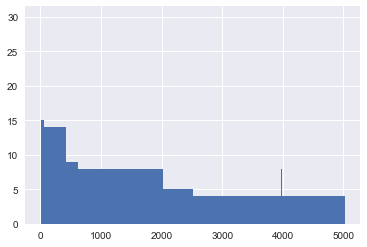

In [41]:
## look at distribution of rank for /r/all posts
## this reflects the inconsistency of my scraper depth
## sometimes as deep as 5000 pages, mostly only 200 pages
## early test data went 0-500 pages deep
plt.hist(df[df['scrape_source']=='https://www.reddit.com/r/all']['rank'],bins=5000);

In [42]:
## non-unique stats
## overall, scraped posts from more than 2,200 subreddits
## 31,500 from /r/all
## 17 subreddits with > 1,700 posts

print(df['scrape_source'].nunique())
df['scrape_source'].value_counts().head(30)

2231


https://www.reddit.com/r/all                     31500
https://www.reddit.com/r/soccer                   1700
https://www.reddit.com/r/BeAmazed                 1700
https://www.reddit.com/r/HighQualityGifs          1700
https://www.reddit.com/r/NatureIsFuckingLit       1700
https://www.reddit.com/r/2meirl4meirl             1700
https://www.reddit.com/r/blackmagicfuckery        1700
https://www.reddit.com/r/StarWars                 1700
https://www.reddit.com/r/worldnews                1700
https://www.reddit.com/r/interestingasfuck        1700
https://www.reddit.com/r/politics                 1700
https://www.reddit.com/r/freefolk                 1700
https://www.reddit.com/r/woahdude                 1700
https://www.reddit.com/r/oddlysatisfying          1700
https://www.reddit.com/r/me_irl                   1700
https://www.reddit.com/r/Showerthoughts           1700
https://www.reddit.com/r/Eyebleach                1700
https://www.reddit.com/r/aww                      1700
https://ww

In [43]:
# Dedupe dataset based on post ID and scrape_source
# Keep highest ranked copy --> peak ranking
# Sort dataset by scrape_source (which subreddit the post was scraped from), then post ID, then rank
# Take the highest-ranked post occurrence
orig = df.shape
df.sort_values(['scrape_source','id','rank'],ascending=False,inplace=True)

df = df.drop(df[df.duplicated(subset=['id','scrape_source'],keep='first')].index,axis=0)
new = df.shape
print("Dropping {} rows for duplicates".format(orig[0]-new[0]))
print("New shape: {}".format(new))

Dropping 561320 rows for duplicates
New shape: (557191, 14)


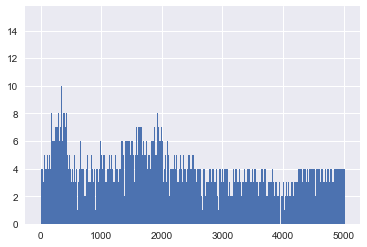

In [44]:
## After deduping dataset
## distribution of page rank is less uniform, more noisy

plt.hist(df[df['scrape_source']=='https://www.reddit.com/r/all']['rank'],bins=5000);

In [45]:
## unique stats
## overall, scraped posts from more than 2,200 subreddits
## 20,004 from /r/all
## 17 subreddits with >= 1,000 posts
## median posts per subreddit: 225
## mean posts per subreddit: 250

print(df['scrape_source'].nunique())
print(df['scrape_source'].value_counts().mean())
df['scrape_source'].value_counts().median()

2231
249.7494397131331


225.0

## EDA & Munging

### EDA

In [46]:
# summarize posts scraped from /r/all
# understand contours of data
df.groupby('scrape_source').count().sort_values('id',ascending=False).head(25)

,author,comments,domain,id,post_time,rank,score,scrape_time,source,time_elapsed,title,url,xposts
scrape_source,,,,,,,,,,,,,
https://www.reddit.com/r/all,20040,20044,16176,20044,20044,20044,20044,20044,20044,20044,20044,20044,18511
https://www.reddit.com/r/AskReddit,1328,1329,0,1329,1329,1329,1329,1329,1329,1329,1329,1329,430
https://www.reddit.com/r/Showerthoughts,1260,1260,0,1260,1260,1260,1260,1260,1260,1260,1260,1260,472
https://www.reddit.com/r/aww,1186,1186,412,1186,1186,1186,1186,1186,1186,1186,1186,1186,412
https://www.reddit.com/r/Music,1182,1182,373,1182,1182,1182,1182,1182,1182,1182,1182,1182,425
https://www.reddit.com/r/mildlyinteresting,1130,1130,421,1130,1130,1130,1130,1130,1130,1130,1130,1130,421
https://www.reddit.com/r/me_irl,1128,1129,400,1129,1129,1129,1129,1129,1129,1129,1129,1129,400
https://www.reddit.com/r/PewdiepieSubmissions,1120,1120,376,1120,1120,1120,1120,1120,1120,1120,1120,1120,376
https://www.reddit.com/r/videos,1119,1119,384,1119,1119,1119,1119,1119,1119,1119,1119,1119,384


In [47]:
DataInspect(df)

Dataframe Shape: (557191, 14) 

Duplicate Rows: 0 

Dataframe Types 

 author                   object
comments                  int64
domain                   object
id                       object
post_time        datetime64[ns]
rank                    float64
score                     int64
scrape_source            object
scrape_time      datetime64[ns]
source                   object
time_elapsed             object
title                    object
url                      object
xposts                  float64
dtype: object 

Missing Values 

 author             1901
comments              0
domain           266738
id                    0
post_time             0
rank                  0
score                 0
scrape_source         0
scrape_time           0
source                0
time_elapsed          0
title                 0
url                   0
xposts           135273
dtype: int64 

Dataframe Describe 

                author       comments     domain               id  \
count 

In [48]:
# missing about 1/2 domain tags
# missing about 1/4 xposts tags
# missing 2000 author tags

df[df['domain'].isnull()].groupby('scrape_source').count().sort_values('id',ascending=False).head(25)

,author,comments,domain,id,post_time,rank,score,scrape_time,source,time_elapsed,title,url,xposts
scrape_source,,,,,,,,,,,,,
https://www.reddit.com/r/all,3866,3868,0,3868,3868,3868,3868,3868,3868,3868,3868,3868,2335
https://www.reddit.com/r/AskReddit,1328,1329,0,1329,1329,1329,1329,1329,1329,1329,1329,1329,430
https://www.reddit.com/r/Showerthoughts,1260,1260,0,1260,1260,1260,1260,1260,1260,1260,1260,1260,472
https://www.reddit.com/r/teenagers,974,976,0,976,976,976,976,976,976,976,976,976,83
https://www.reddit.com/r/Jokes,914,914,0,914,914,914,914,914,914,914,914,914,409
https://www.reddit.com/r/AskOuija,874,874,0,874,874,874,874,874,874,874,874,874,440
https://www.reddit.com/r/WritingPrompts,839,839,0,839,839,839,839,839,839,839,839,839,199
https://www.reddit.com/r/DnD,839,839,0,839,839,839,839,839,839,839,839,839,316
https://www.reddit.com/r/pcmasterrace,838,838,0,838,838,838,838,838,838,838,838,838,137


In [49]:
df[df['xposts'].isnull()].groupby('scrape_source').count().sort_values('id',ascending=False).head(25)

,author,comments,domain,id,post_time,rank,score,scrape_time,source,time_elapsed,title,url,xposts
scrape_source,,,,,,,,,,,,,
https://www.reddit.com/r/all,1532,1533,0,1533,1533,1533,1533,1533,1533,1533,1533,1533,0
https://www.reddit.com/r/AskReddit,899,899,0,899,899,899,899,899,899,899,899,899,0
https://www.reddit.com/r/teenagers,891,893,0,893,893,893,893,893,893,893,893,893,0
https://www.reddit.com/r/Showerthoughts,788,788,0,788,788,788,788,788,788,788,788,788,0
https://www.reddit.com/r/aww,774,774,0,774,774,774,774,774,774,774,774,774,0
https://www.reddit.com/r/pics,760,760,0,760,760,760,760,760,760,760,760,760,0
https://www.reddit.com/r/Music,757,757,0,757,757,757,757,757,757,757,757,757,0
https://www.reddit.com/r/PewdiepieSubmissions,744,744,0,744,744,744,744,744,744,744,744,744,0
https://www.reddit.com/r/videos,735,735,0,735,735,735,735,735,735,735,735,735,0


In [50]:
# I decided to drop columns instead of observations because I would be throwing away entire subreddits
# trim dataset to relevant columns

df.drop(['author','domain','xposts'],axis=1,inplace=True)

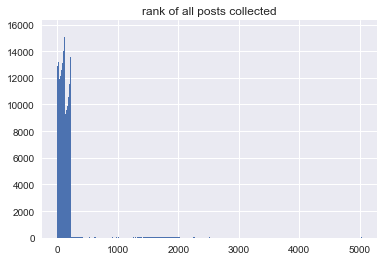

In [51]:
# most posts collected ranked less than 500
# this reflects that I shallowly scrapped subreddits
# often ~200 posts deep
# while I scrapped /r/all to 5000 posts on occasions

plt.hist(df['rank'],bins=1000)
_ = plt.title('rank of all posts collected')

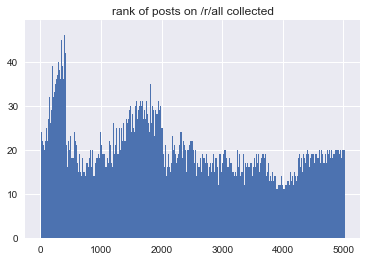

In [52]:
plt.hist(df[df['scrape_source']=='https://www.reddit.com/r/all']['rank'],bins=1000)
_ = plt.title('rank of posts on /r/all collected');

In [53]:
print('median 6 comments across all posts')
df['comments'].describe()

median 6 comments across all posts


count    557191.000000
mean         27.440782
std         175.189117
min           0.000000
25%           2.000000
50%           6.000000
75%          16.000000
max       25900.000000
Name: comments, dtype: float64

In [54]:
print('median 20 comments on /r/all posts')
df[(df['scrape_source']=='https://www.reddit.com/r/all')].describe()

median 20 comments on /r/all posts


,comments,rank,score
count,20044.000000,20044.000000,20044.000000
mean,100.414189,2284.623379,2182.373279
std,423.050320,1468.169995,7068.426421
min,0.000000,1.000000,2.000000
25%,7.000000,1069.750000,81.000000
50%,20.000000,2065.000000,217.000000
75%,61.000000,3500.000000,863.000000
max,17187.000000,5025.000000,122350.000000


In [55]:
print('/r/all \n')
print(df[df['scrape_source']=='https://www.reddit.com/r/all'].describe())
print('\n /r/all <=2000 \n')
print(df[(df['scrape_source']=='https://www.reddit.com/r/all') & (df['rank']<=2000)].describe())
print('\n /r/all > 2000 \n')
print(df[(df['scrape_source']=='https://www.reddit.com/r/all') & (df['rank']>2000)].describe())

/r/all 

           comments          rank          score
count  20044.000000  20044.000000   20044.000000
mean     100.414189   2284.623379    2182.373279
std      423.050320   1468.169995    7068.426421
min        0.000000      1.000000       2.000000
25%        7.000000   1069.750000      81.000000
50%       20.000000   2065.000000     217.000000
75%       61.000000   3500.000000     863.000000
max    17187.000000   5025.000000  122350.000000

 /r/all <=2000 

           comments         rank          score
count   9741.000000  9741.000000    9741.000000
mean     153.095165  1005.914793    3801.784930
std      539.216235   616.689346    8998.413293
min        0.000000     1.000000       3.000000
25%       11.000000   394.000000     165.000000
50%       33.000000  1031.000000     515.000000
75%      106.000000  1573.000000    2540.000000
max    17187.000000  2000.000000  122350.000000

 /r/all > 2000 

           comments          rank          score
count  10303.000000  10303.000000

In [56]:
## at this moment, I am choosing to only focus on differentiating high/low commented posts on /r/all
## I will return to /r/all vs reddit later

# stashing /r/all separate from all reddits

r_all = df[df['scrape_source']=='https://www.reddit.com/r/all'].copy()

### Feature Engineering: Outcome (Median Comments)

#### Creation

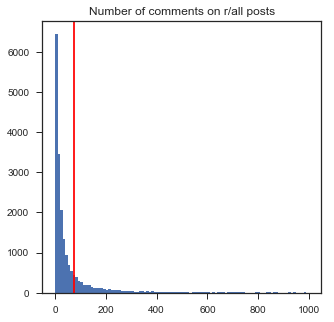

In [57]:
# post comments have a very long tail
# even on the front page
# skewed right
sns.set(style = 'ticks')

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
_ = plt.hist(x=r_all[r_all['comments']<1000]['comments'],bins=100)
_ = plt.axvline(75,color='red')
_ = plt.title('Number of comments on r/all posts')

In [58]:
zrange = np.arange(0,101,10)
np.percentile(r_all['comments'],zrange)

array([  0.00000000e+00,   2.00000000e+00,   5.00000000e+00,
         9.00000000e+00,   1.30000000e+01,   2.00000000e+01,
         3.00000000e+01,   4.70000000e+01,   8.24000000e+01,
         1.87000000e+02,   1.71870000e+04])

##### Presentation Chart

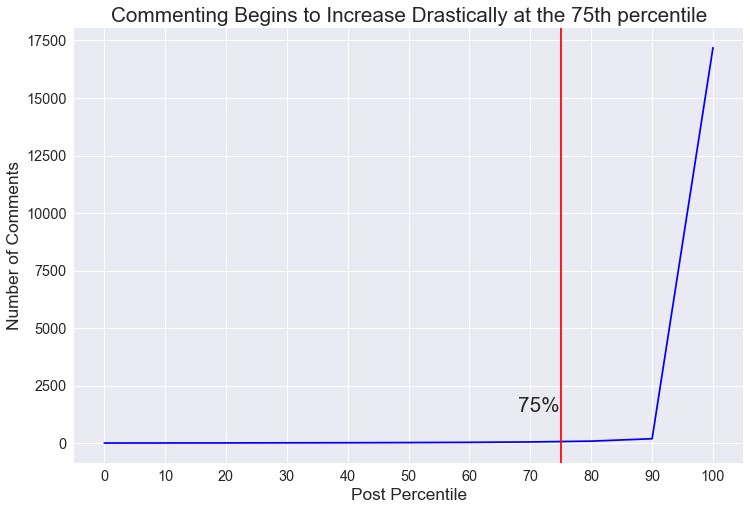

In [59]:
sns.set(style='darkgrid')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

_ = plt.plot(zrange,np.percentile(r_all['comments'],zrange),color='b')
_ = plt.xticks(np.arange(0,110,10),fontsize='large')
_ = plt.xlabel('Post Percentile',fontsize='x-large')
_ = plt.yticks(fontsize='large')
_ = plt.ylabel('Number of Comments',fontsize='x-large')
_ = plt.axvline(75,color='r')
_ = plt.text(68,1350,'75%',fontsize='xx-large')

_ = plt.title('Commenting Begins to Increase Drastically at the 75th percentile',fontsize='xx-large')

#plt.savefig('presentation/percentiles.jpg')

#### Code

In [60]:
# basic outcome variable: whether r/all posts will have above or below median number of comments
# create binary variable for +/- median comments on r_all
print('Median: {}'.format(np.median(r_all['comments'])))
print('75th: {}'.format(np.percentile(r_all['comments'],75)))
print('\n')

r_all['high_low'] = r_all['comments'].apply(lambda x: 1 if x > np.percentile(r_all['comments'],75) else 0)

#verify
print(r_all['high_low'].describe())
r_all[['high_low','comments']].head(25)

Median: 20.0
75th: 61.0


count    20044.000000
mean         0.248902
std          0.432388
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: high_low, dtype: float64


,high_low,comments
1124656,0,0
1124660,0,21
1127029,0,2
1126489,0,6
1125026,0,11
1126738,0,1
1127008,0,7
1123927,0,41
1125885,0,1
1124767,0,3


#### EDA with median/comments

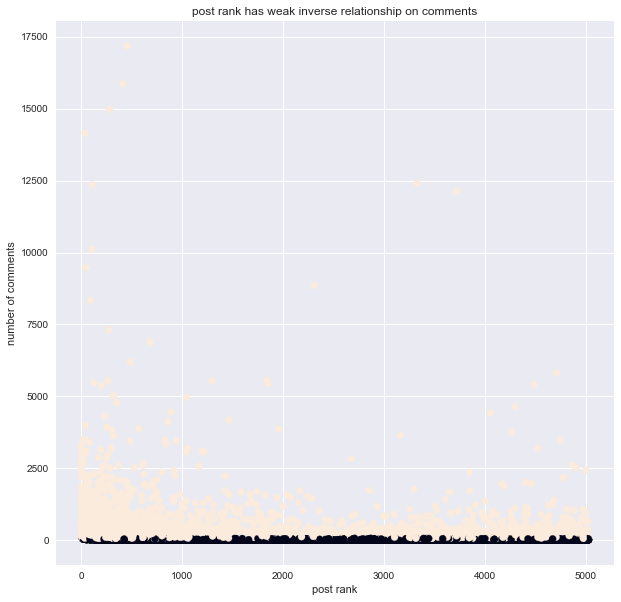

In [61]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.scatter(r_all[r_all['comments'] > 0]['rank'],
            (r_all[r_all['comments']>0]['comments']),
            c=r_all[r_all['comments']>0]['high_low'])
_=plt.xlabel('post rank')
_=plt.ylabel('number of comments')
_=plt.title('post rank has weak inverse relationship on comments')

In [62]:
np.corrcoef(r_all['comments'],r_all['rank'])

array([[ 1.        , -0.14719444],
       [-0.14719444,  1.        ]])

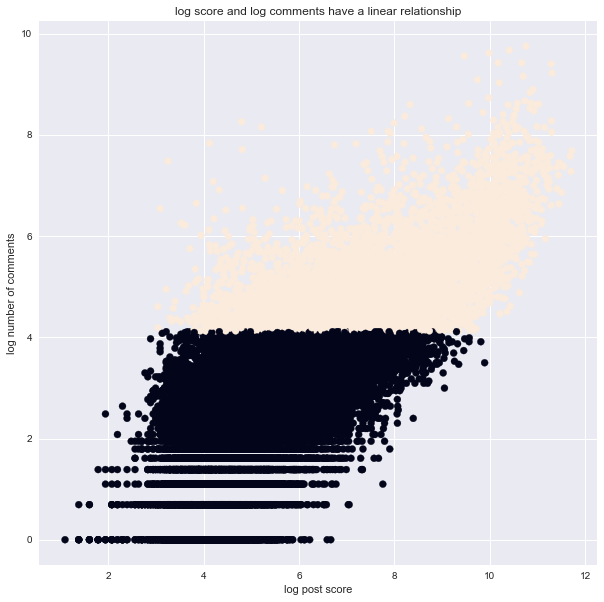

In [63]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.scatter(np.log(r_all[r_all['comments'] > 0]['score']),
            np.log(r_all[r_all['comments']>0]['comments']),
            c=r_all[r_all['comments']>0]['high_low'])
_=plt.xlabel('log post score')
_=plt.ylabel('log number of comments')
_=plt.title('log score and log comments have a linear relationship')

In [64]:
np.corrcoef(np.log(r_all[r_all['comments']>0]['score']),np.log(r_all[r_all['comments']>0]['comments']))

array([[ 1.       ,  0.7334555],
       [ 0.7334555,  1.       ]])

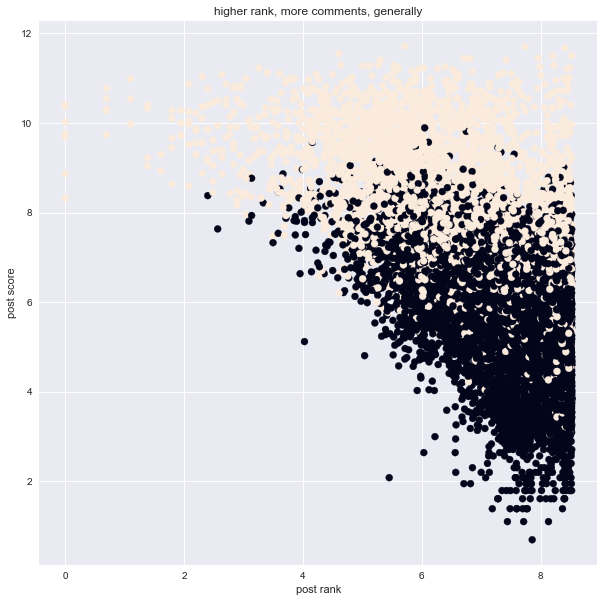

In [65]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.scatter(np.log(r_all['rank']),
            np.log(r_all['score']),
            c=r_all['high_low'])
_=plt.xlabel('post rank')
_=plt.ylabel('post score')
_=plt.title('higher rank, more comments, generally')

In [66]:
np.corrcoef(np.log(r_all['rank']),np.log(r_all['score']))

array([[ 1.        , -0.61346071],
       [-0.61346071,  1.        ]])

In [67]:
#posts on r/all have average more comments than reddit overall (cluster sampled)
#median number of comments on r/all is 20
#median number of comments overall is 6

print('comments on /r/all \n')
print(r_all['comments'].describe())
print('\n comments on reddit posts \n')
print(df['comments'].describe())

comments on /r/all 

count    20044.000000
mean       100.414189
std        423.050320
min          0.000000
25%          7.000000
50%         20.000000
75%         61.000000
max      17187.000000
Name: comments, dtype: float64

 comments on reddit posts 

count    557191.000000
mean         27.440782
std         175.189117
min           0.000000
25%           2.000000
50%           6.000000
75%          16.000000
max       25900.000000
Name: comments, dtype: float64


Are the number of average comments really different?

$H_0$: $\mu_{r/all}$ = $\mu_{reddit}$

$H_A$: $\mu_{r/all}$ $\neq$ $\mu_{reddit}$

$\alpha$ = 0.05

In [68]:
from scipy import stats

print('mean comments on r/all: {}'.format(r_all['comments'].mean()))
print('mean comments on reddit posts: {}'.format(df[df['scrape_source']!=
                                                    'https://www.reddit.com/r/all']['comments'].mean()))

stats.ttest_ind(r_all['comments'],df[df['scrape_source']!='https://www.reddit.com/r/all']['comments'])

mean comments on r/all: 100.41418878467371
mean comments on reddit posts: 24.717730900479758


Ttest_indResult(statistic=60.258076766212206, pvalue=0.0)

We reject the null hypothesis and accept the alternative hypothesis that the average number of comments on /r/all posts is different than the number of average comments on subreddits on the rest of reddit at the 99 percent confidence level.

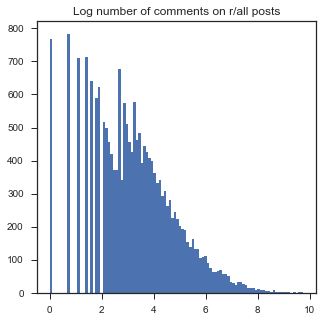

In [69]:
# post comments have a very long tail
# even on the front page
# log comments looks more Normal
sns.set(style = 'ticks')

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
_ = plt.hist(x=np.log(r_all[r_all['comments']>0]['comments']),bins=100)
_ = plt.title('Log number of comments on r/all posts')

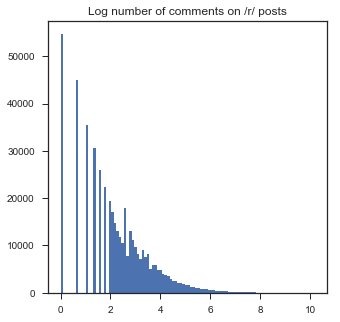

In [70]:
# post comments have a very long tail
# looking across all scraped posts
# skewed right
sns.set(style = 'ticks')

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
_ = plt.hist(x=np.log(df[(df['comments']>0) & (df['rank'] < 2025)]['comments']),bins=100)
_ = plt.title('Log number of comments on /r/ posts')


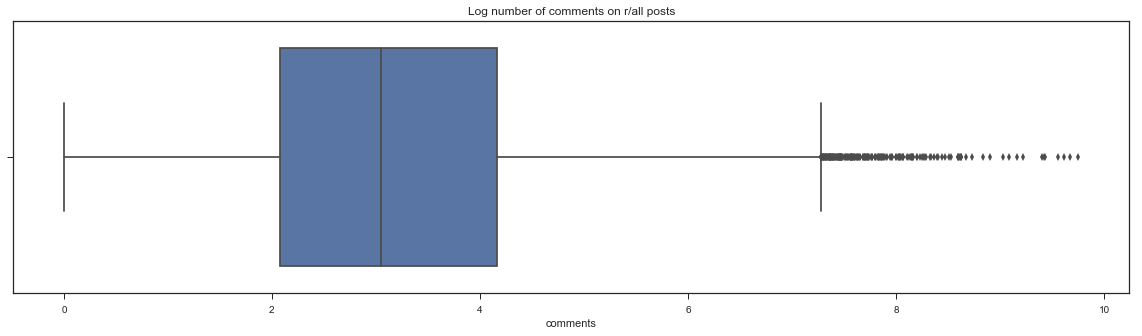

In [71]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)

sns.boxplot(x=np.log(r_all[r_all['comments']>0]['comments']))
_ = plt.title('Log number of comments on r/all posts')

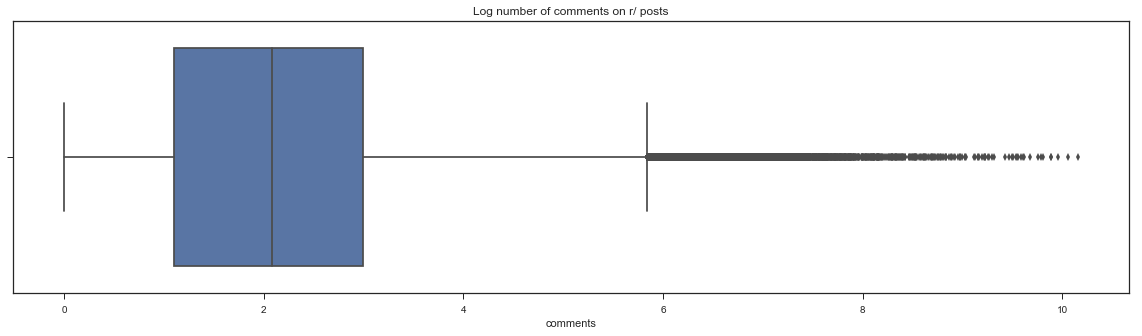

In [72]:
# log number of comments on r/ posts
# rightward skew

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)

sns.boxplot(x=np.log(df[(df['comments']>0) & (df['rank'] < 2025)]['comments']))
_ = plt.title('Log number of comments on r/ posts')

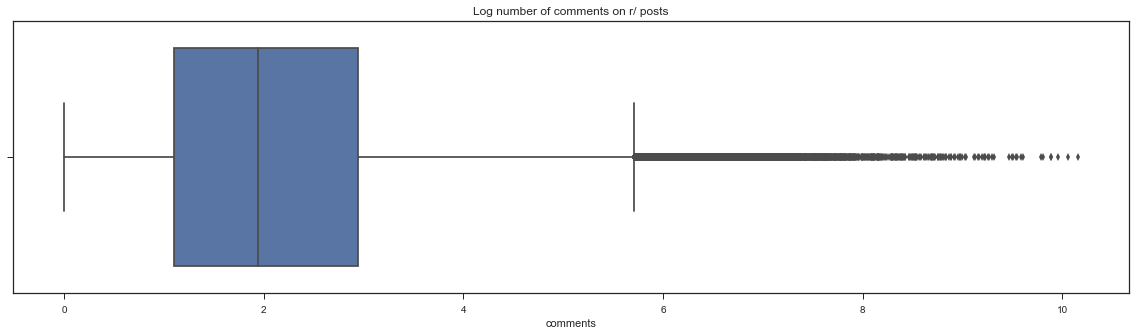

In [73]:
# log number of comments on posts EXCLUDING r/all
# rightward skew
# not dissimilar from overall (above)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)

sns.boxplot(x=np.log(df[(df['comments']>0) & (df['scrape_source'] != 'https://www.reddit.com/r/all')]['comments']))
_ = plt.title('Log number of comments on r/ posts')

### Feature Engineering: Freshness

In [74]:
# is there a relationship between post_time and comments
# create feature 'freshness': elapsed time between post and scrape

r_all['freshness'] = r_all['scrape_time'] - r_all['post_time']
r_all['freshness'] = r_all['freshness'].apply(lambda x: x.total_seconds() / 60)
r_all['freshness'].describe()

count     20044.000000
mean        717.731869
std        8664.579279
min           0.366667
25%         283.787500
50%         469.450000
75%         780.862500
max      980928.333333
Name: freshness, dtype: float64

In [75]:
np.corrcoef(r_all['comments'],r_all['freshness'])

array([[ 1.        ,  0.00355879],
       [ 0.00355879,  1.        ]])

In [76]:
np.corrcoef(r_all['high_low'],r_all['freshness'])

array([[ 1.        ,  0.00848525],
       [ 0.00848525,  1.        ]])

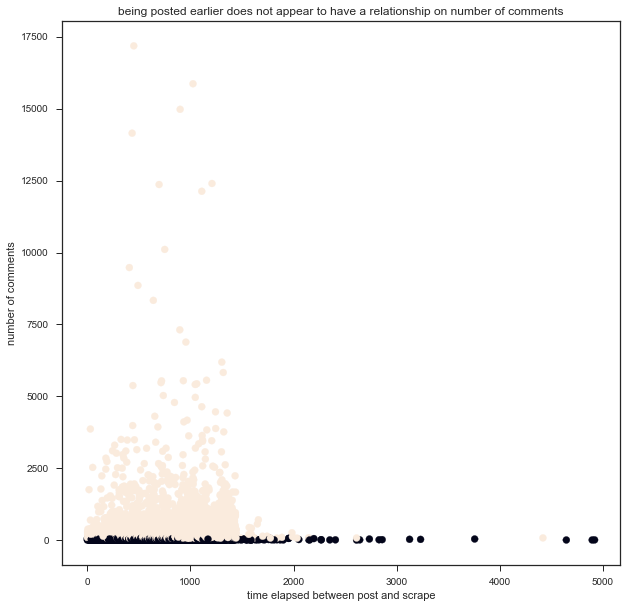

In [77]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.scatter(r_all[(r_all['comments']>0) & (r_all['freshness']<5000)]['freshness'],
            (r_all[(r_all['comments']>0) & (r_all['freshness']<5000)]['comments']),
           c=r_all[(r_all['comments']>0) & (r_all['freshness']<5000)]['high_low'])
_ = plt.xlabel('time elapsed between post and scrape')
_ = plt.ylabel('number of comments')
_ = plt.title('being posted earlier does not appear to have a relationship on number of comments')

### Feature Engineering: Title Length

In [78]:
# create feature for length of title (characters)

r_all['length'] = r_all['title'].apply(lambda x: len(x))
r_all['length'].describe()

count    20044.000000
mean        55.600629
std         47.855284
min          1.000000
25%         24.000000
50%         42.000000
75%         71.000000
max        308.000000
Name: length, dtype: float64

In [79]:
np.corrcoef(r_all['comments'],r_all['length'])

array([[ 1.        ,  0.08538198],
       [ 0.08538198,  1.        ]])

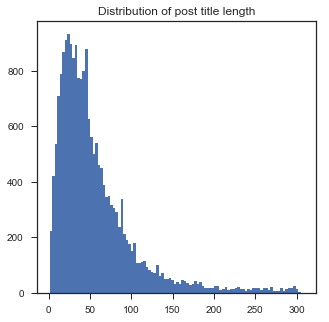

In [80]:
sns.set(style = 'ticks')

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
_ = plt.hist(x=r_all['length'],bins=100)
_ = plt.title('Distribution of post title length')

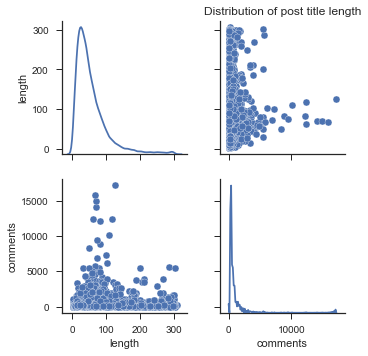

In [81]:
sns.set(style = 'ticks')

_ = sns.pairplot(r_all[['length','comments']],diag_kind='kde')
_ = plt.title('Distribution of post title length')

### Feature Engineering: Time of Day

In [82]:
#create categorical time of day for posts, then create dummies
# https://pymotw.com/2/datetime/

day_time = []
for x in r_all['post_time']:
    if (x.time() >= datetime.time(0, 0, 0)) and (x.time() < datetime.time(2, 0, 0)):
        day_time.append('late night')
    elif (x.time() >= datetime.time(2, 0, 0)) and (x.time() < datetime.time(6, 0, 0)):
        day_time.append('early AM')
    elif (x.time() >= datetime.time(6, 0, 0)) and (x.time() < datetime.time(10, 0, 0)):
        day_time.append('late AM')
    elif (x.time() >= datetime.time(10, 0, 0)) and (x.time() < datetime.time(14, 0, 0)):
        day_time.append('midday')
    elif (x.time() >= datetime.time(14, 0, 0)) and (x.time() < datetime.time(18, 0, 0)):
        day_time.append('early PM')
    elif (x.time() >= datetime.time(18, 0, 0)) and (x.time() < datetime.time(22, 0, 0)):
        day_time.append('late PM')
    elif (x.time() >= datetime.time(22, 0, 0)):
        day_time.append('late night')

day_time = pd.DataFrame(day_time)
day_time.rename(columns={0:'day_time'},inplace=True)

print('Day time shape is {}'.format(day_time.shape))
print('R_all shape is {}'.format(r_all.shape))

#r_all.reset_index(inplace=True)
r_all = pd.concat([r_all.reset_index(),day_time],axis=1,join='inner').drop('index',axis=1)
print('Resultant df shape is {}'.format(r_all.shape))

Day time shape is (20044, 1)
R_all shape is (20044, 14)
Resultant df shape is (20044, 15)


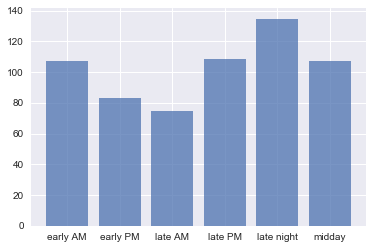

In [88]:
comments_per_post = r_all.groupby('day_time').agg({'comments':'sum','id':'count'})['comments'] / r_all.groupby('day_time').agg({'comments':'sum','id':'count'})['id']
#print(comments_per_post)
xrange = np.arange(1,7,1)

_ = plt.bar(xrange, comments_per_post,alpha=0.75)
_ = plt.xticks(xrange, (comments_per_post.index))

##### Presentation table data

In [84]:
r_all.columns

Index(['comments', 'id', 'post_time', 'rank', 'score', 'scrape_source',
       'scrape_time', 'source', 'time_elapsed', 'title', 'url', 'high_low',
       'freshness', 'length', 'day_time'],
      dtype='object')

In [85]:
pd.crosstab(index=r_all['source'],columns=r_all['day_time'],normalize='columns').sort_values('late night',ascending=False)

day_time,early AM,early PM,late AM,late PM,late night,midday
source,,,,,,
r/aww,0.004957,0.002294,0.002626,0.002886,0.005295,0.003534
r/politics,0.004957,0.004424,0.000000,0.006094,0.004888,0.004476
r/PoliticalHumor,0.001352,0.001966,0.000525,0.002245,0.004888,0.002120
r/funny,0.005858,0.002786,0.005252,0.003849,0.004481,0.003298
r/mildlyinteresting,0.001803,0.002130,0.001576,0.001924,0.004481,0.000942
r/guns,0.000901,0.002294,0.000000,0.000962,0.004481,0.000471
r/OldSchoolCool,0.003605,0.001311,0.002101,0.000641,0.004481,0.002120
r/pics,0.005858,0.002294,0.001576,0.003528,0.004073,0.002356
r/gaming,0.002253,0.002949,0.006303,0.002886,0.004073,0.002827


##### Presentation Chart

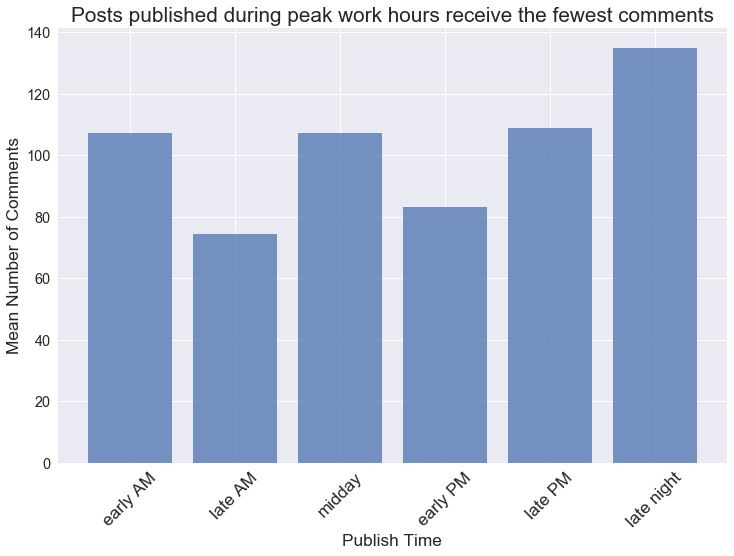

In [86]:
comments_per_post = comments_per_post.reindex(['early AM',
                                               'late AM','midday','early PM','late PM', 'late night'])

sns.set(style = 'darkgrid')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

xrange = np.arange(1,7,1)

_ = plt.bar(xrange, comments_per_post,alpha=0.75)
_ = plt.xticks(xrange, (comments_per_post.index),fontsize='x-large',rotation=45)
_ = plt.yticks(fontsize='large')
_ = plt.xlabel('Publish Time',fontsize='x-large')
_ = plt.ylabel('Mean Number of Comments',fontsize='x-large')
_ = plt.title('Posts published during peak work hours receive the fewest comments',fontsize='xx-large')

#plt.savefig('presentation/comments.jpg')

Are the average comments per time period really different?

$H_0$: $\mu_{early AM}$ = $\mu_{late AM}$ = $\mu_{midday}$ = $\mu_{early PM}$ = $\mu_{late PM}$ = $\mu_{late night}$

$H_A$: $\mu_{i}$ $\neq$ $\mu_{j}$

$\alpha$ = 0.05

At the $\alpha$ = 0.05 level, we reject the null hypothesis and conclude that at least one mean is different

In [93]:
from scipy import stats
stats.f_oneway(r_all[r_all['day_time']=='early AM']['comments'],
r_all[r_all['day_time']=='late AM']['comments'],
r_all[r_all['day_time']=='midday']['comments'],
r_all[r_all['day_time']=='early PM']['comments'],
r_all[r_all['day_time']=='late PM']['comments'],
r_all[r_all['day_time']=='late night']['comments'])

F_onewayResult(statistic=7.3230946942083825, pvalue=7.2541330340433197e-07)

### Feature Engineering: Dummies

In [94]:
dummies = pd.get_dummies(r_all[['source','day_time']])
r_all = pd.concat([r_all,dummies],join='inner',axis=1)

## Train-Test-Split

In [95]:
## define target variable 
y = r_all['high_low']
X_all = r_all.drop('high_low',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X_all,y,
                                                 test_size = 0.3,random_state=20180223)

print('X_all:{} \n X_train:{} \n X_test:{} \n y:{} \n y_train:{} \n y_test:{}'.format(
    X_all.shape,X_train.shape,X_test.shape,y.shape,y_train.shape,y_test.shape))

X_all:(20044, 3141) 
 X_train:(14030, 3141) 
 X_test:(6014, 3141) 
 y:(20044,) 
 y_train:(14030,) 
 y_test:(6014,)


## Feature Engineering: Title Processing

Using TF-IDF here to vectorize the title strings because I'm interested in what makes posts with more comments different from posts with fewer comments. Word frequency in a title isn't of interest, since (a) titles are short so it's unlikely to have repeated words and (2) doesn't account for differences in frequency of words across the corpus.

Testing a couple different vectorization parameters

In [96]:
#built during relevant lab

import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

#keep only letters, or !/? from titles
substring = "[^a-zA-Z!\?]"
#call words anything separated by whitespace
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
#reduce words to their roots
lemmatizer = WordNetLemmatizer()

def clean_words(bad_words,stop=True):
    #strip punctuation except !
    letters_only = bad_words.apply(lambda x: re.sub(substring," ",x))
    
    #tokenize strings
    split_strings = [tokenizer.tokenize(l.lower()) for l in letters_only]
    
    if stop == False:
        real_words = split_strings
    else:
        #set from stop words
        from nltk.corpus import stopwords
        stops = set(stopwords.words("english"))  
    
        #filter out stop words
        real_words = [[s for s in string if not s in stops] for string in split_strings]

    #find base words where possible
    base_words = [[lemmatizer.lemmatize(w) for w in rw] for rw in real_words]
    
    #return joined space-separated strings
    return [" ".join(bw) for bw in base_words]

In [97]:
X_train.loc[:,'clean_titles'] = clean_words(X_train['title'],stop=True)
X_train.loc[:,'clean_titles_stop'] = clean_words(X_train['title'],stop=False)

/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [98]:
# NLP: TF-IDF Vectorizer WITHOUT stop words

tfidf = TfidfVectorizer(max_features=5000)
tfidfdata = tfidf.fit_transform(X_train['clean_titles'])

X_tfidf = pd.DataFrame(tfidfdata.todense(),
                      columns=tfidf.get_feature_names(),
                      index=X_train.index)
X_tfidf.shape

(14030, 5000)

In [99]:
# NLP: TF-IDF Vectorizer WITHOUT stop words, WITH n_gram <= 3

tfidfng = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
tfidfngdata = tfidfng.fit_transform(X_train['clean_titles'])

X_tfidfng = pd.DataFrame(tfidfngdata.todense(),
                      columns=tfidfng.get_feature_names(),
                        index=X_train.index)
X_tfidfng.shape

(14030, 5000)

In [100]:
# NLP: TF-IDF Vectorizer INCLUSIVE stop words

tfidfs = TfidfVectorizer(max_features=5000)
tfidfsdata = tfidfs.fit_transform(X_train['clean_titles_stop'])

X_tfidfs = pd.DataFrame(tfidfsdata.todense(),
                      columns=tfidfs.get_feature_names(),
                       index=X_train.index)
X_tfidfs.shape

(14030, 5000)

In [101]:
# NLP: TF-IDF Vectorizer INCLUSIVE stop words, WITH n_gram <= 3

tfidfsng = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
tfidfsngdata = tfidfsng.fit_transform(X_train['clean_titles_stop'])

X_tfidfsng = pd.DataFrame(tfidfsngdata.todense(),
                      columns=tfidfsng.get_feature_names(),
                         index=X_train.index)
X_tfidfsng.shape

(14030, 5000)

## Modeling

#### Thought experiment: What is the baseline accuracy for this model?
For a model which predicts each post will have the median number of comments (20), the baseline accuracy would be 50%. Fifty (50) percent of posts are below this threshold, 50 percent are above, so we would be right half the time if we only used the median to predict.

In my case, I've tweaked this to predict posts over the 75% threshold. If my model simply predicted every post to have the over/under the 75th percentile (61 comments), I would expect it to be right 75% of the time (assuming that I inverted the predictive classes such that I was predicting under 61 comments). 

Your piece is going to be on how to create a Reddit post that will get the most engagement from Reddit users. Because this is FiveThirtyEight, you're going to have to get data and analyze it in order to make a compelling narrative.

_What characteristics of a post on Reddit are most predictive of the overall interaction on a thread (as measured by number of comments)?_

*Where am I going from here?*

- Random forest using only the subreddit source
- transform and vectorize the title string text

Two objectives:
1. predict the quantity of comments (above/below) median
    - using only the subreddit source
    - using title text
    - using subreddit source, title text

2. can I identify posts that have above median number of comments across the whole of reddit?
    - build a sample frame from scraped data
    - how do front page articles differ from other posts with less engagement?
    - build similar models to (1) but with a different dependent variable (on front page, not on front page)
    

- Implementing 1:
    - random forest
    - logistic regression
- Implementing 2:
    - logistic regression with class balancing
- NLP
    - clean language

### 1. Use a Random Forest model to predict High/Low number of comments using Sklearn. 
Only use the subreddit as a feature.

In [102]:
scores = {}
test_scores = {}

In [103]:
dummies = [c for c in X_train.columns if 'source_' in c ]

In [104]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20180220)

rfc = RandomForestClassifier(class_weight='balanced_subsample')
s = cross_val_score(rfc,X_train[dummies], y_train, cv=cv, n_jobs=-1)
scores[1] = s.mean()
rfc = rfc.fit(X_train[dummies],y_train)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.718 ± 0.007


In [105]:
test = rfc.score(X_test[dummies],y_test)
test_scores[1] = test
print("{} Test Score:\t{:0.3}".format("Random Forest", test.round(3)))

Random Forest Test Score:	0.699


In [106]:
basic_rfc_features = pd.DataFrame(rfc.feature_importances_,
                      index=X_train[dummies].columns)
basic_rfc_features.rename(columns={0:'importance'},inplace=True)

basic_rfc_features.sort_values('importance',ascending=False).head(25)

,importance
source_r/politics,0.017985
source_r/nba,0.015205
source_r/gaming,0.011525
source_r/news,0.010141
source_r/gifs,0.009626
source_r/worldnews,0.009289
source_r/leagueoflegends,0.009049
source_r/todayilearned,0.008638
source_r/soccer,0.008455
source_r/The_Donald,0.008434


### 2. Random Forest with Subreddit, Titles (TF-IDF: w/o stop; ngrams=1)

In [107]:
dummies = [c for c in X_train.columns if 'source_' in c ]

Xd_train = X_train[dummies]
Xd_tfidf = pd.concat([Xd_train,X_tfidf],axis=1,join='inner')
assert Xd_tfidf.shape[0] == X_train.shape[0]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20180220)

rfc = RandomForestClassifier(class_weight='balanced_subsample')
s = cross_val_score(rfc, Xd_tfidf, y_train, cv=cv,n_jobs=-1)
scores[2] = s.mean()
rfc = rfc.fit(Xd_tfidf,y_train)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.759 ± 0.005


In [108]:
# Score test data
# apply same data transformations as training set

# clean titles
X_test.loc[:,'clean_titles'] = clean_words(X_test['title'],stop=True)

# get dummies
Xd_test = X_test[dummies]
# transform w/appropriate vectorizer
Xtfidf_test_data = tfidf.transform(X_test['clean_titles'])
# to dense
Xtfidf_test = pd.DataFrame(Xtfidf_test_data.todense(),
                      columns=tfidf.get_feature_names(),
                      index=X_test.index)

#join independent variables
Xd_tfidf_test = pd.concat([Xd_test,Xtfidf_test],axis=1,join='inner')

assert Xd_tfidf_test.shape[0] == X_test.shape[0]

#score
test = rfc.score(Xd_tfidf_test,y_test)
test_scores[2] = test
print("{} Test Score:\t{:0.3}".format("Random Forest", test.round(3)))

/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Random Forest Test Score:	0.762


In [109]:
rfc_tfidf_features = pd.DataFrame(rfc.feature_importances_,
                      index=Xd_tfidf.columns)
rfc_tfidf_features.rename(columns={0:'importance'},inplace=True)

rfc_tfidf_features.sort_values('importance',ascending=False).head(25)

,importance
source_r/politics,0.005734
source_r/nba,0.005513
source_r/gifs,0.004423
source_r/gaming,0.004269
source_r/videos,0.004217
source_r/AskReddit,0.004010
source_r/funny,0.003904
source_r/pics,0.003555
source_r/soccer,0.003306
source_r/CringeAnarchy,0.002976


### 3. Random Forest with Subreddit, Titles (TF-IDF: w/o stop; w/ngrams=(1,3))

In [110]:
dummies = [c for c in X_train.columns if 'source_' in c ]

Xd = X_train[dummies]
Xd_tfidfng = pd.concat([Xd,X_tfidfng],axis=1,join='inner')
assert Xd_tfidfng.shape[0] == X_train.shape[0]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20180220)

rfc = RandomForestClassifier(class_weight='balanced_subsample')
s = cross_val_score(rfc, Xd_tfidfng, y_train, cv=cv,n_jobs=-1)
scores[3] = s.mean()
rfc = rfc.fit(Xd_tfidfng,y_train)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.76 ± 0.007


In [111]:
# score test data
# apply same data transformations as training set

# clean titles
X_test.loc[:,'clean_titles'] = clean_words(X_test['title'],stop=True)

# get dummies
Xd_test = X_test[dummies]
# transform with appropriate vectorizer
Xtfidfng_test_data = tfidfng.transform(X_test['clean_titles'])
# to dense
Xtfidfng_test = pd.DataFrame(Xtfidfng_test_data.todense(),
                      columns=tfidfng.get_feature_names(),
                      index=X_test.index)
# join independent variables
Xd_tfidfng_test = pd.concat([Xd_test,Xtfidfng_test],axis=1,join='inner')
#verify
assert Xd_tfidfng_test.shape[0] == X_test.shape[0]
#score
test = rfc.score(Xd_tfidfng_test,y_test)
test_scores[3] = test
print("{} Test Score:\t{:0.3}".format("Random Forest", test.round(3)))

/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Random Forest Test Score:	0.766


In [112]:
rfc_tfidfng_features = pd.DataFrame(rfc.feature_importances_,
                      index=Xd_tfidfng.columns)
rfc_tfidfng_features.rename(columns={0:'importance'},inplace=True)

rfc_tfidfng_features.sort_values('importance',ascending=False).head(25)

,importance
source_r/politics,0.006748
source_r/nba,0.005829
source_r/gifs,0.004224
source_r/gaming,0.004132
source_r/videos,0.003993
source_r/funny,0.003764
new,0.003763
source_r/pics,0.003729
source_r/AskReddit,0.003691
source_r/worldnews,0.003473


### 4. Random Forest with Subreddit, Titles (TF-IDF: w/stop; ngrams=1)

In [113]:
dummies = [c for c in X_train.columns if 'source_' in c ]

Xd = X_train[dummies]
Xd_tfidfs = pd.concat([Xd,X_tfidfs],axis=1,join='inner')
assert Xd_tfidfs.shape[0] == X_train.shape[0]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20180220)

rfc = RandomForestClassifier(class_weight='balanced_subsample')
s = cross_val_score(rfc, Xd_tfidfs, y_train, cv=cv,n_jobs=-1)
scores[4] = s.mean()
rfc = rfc.fit(Xd_tfidfs,y_train)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.76 ± 0.005


In [114]:
# score test data
# apply same transformations as training set

# clean titles -- include stop words
X_test.loc[:,'clean_titles_stop'] = clean_words(X_test['title'],stop=False)
# get dummies
Xd_test = X_test[dummies]
# transform with vectorizer
Xtfidfs_test_data = tfidfs.transform(X_test['clean_titles_stop'])

# to dense
Xtfidfs_test = pd.DataFrame(Xtfidfs_test_data.todense(),
                      columns=tfidfs.get_feature_names(),
                      index=X_test.index)
# join independent vars
Xd_tfidfs_test = pd.concat([Xd_test,Xtfidfs_test],axis=1,join='inner')
#verify
assert Xd_tfidfs_test.shape[0] == X_test.shape[0]
#score
test = rfc.score(Xd_tfidfs_test,y_test)
test_scores[4] = test
print("{} Test Score:\t{:0.3}".format("Random Forest", test.round(3)))

/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Random Forest Test Score:	0.772


In [115]:
rfc_tfidfs_features = pd.DataFrame(rfc.feature_importances_,
                      index=Xd_tfidfs.columns)
rfc_tfidfs_features.rename(columns={0:'importance'},inplace=True)

rfc_tfidfs_features.sort_values('importance',ascending=False).head(25)

,importance
the,0.010359
to,0.007375
in,0.006555
source_r/politics,0.005722
of,0.005368
is,0.005244
for,0.005021
on,0.004909
this,0.004899
and,0.004817


### 5. Random Forest with Subreddit, Titles (TF-IDF: w/stop; ngrams=(1,3))

In [116]:
dummies = [c for c in X_train.columns if 'source_' in c ]

Xd = X_train[dummies]
Xd_tfidfsng = pd.concat([Xd,X_tfidfsng],axis=1,join='inner')
assert Xd_tfidfsng.shape[0] == X_train.shape[0]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20180220)

rfc = RandomForestClassifier(class_weight='balanced_subsample')
s = cross_val_score(rfc, Xd_tfidfsng, y_train, cv=cv,n_jobs=-1)
scores[5] = s.mean()
rfc = rfc.fit(Xd_tfidfsng,y_train)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.758 ± 0.004


In [117]:
# score test data
# apply same transformations
X_test.loc[:,'clean_titles_stop'] = clean_words(X_test['title'],stop=False)
# get dummies
Xd_test = X_test[dummies]
# use appropriate vectorizer - include stops & ngrams
Xtfidfsng_test_data = tfidfsng.transform(X_test['clean_titles_stop'])
# to dense
Xtfidfsng_test = pd.DataFrame(Xtfidfsng_test_data.todense(),
                      columns=tfidfsng.get_feature_names(),
                      index=X_test.index)
# join independent vars
Xd_tfidfsng_test = pd.concat([Xd_test,Xtfidfsng_test],axis=1,join='inner')
# verify
assert Xd_tfidfsng_test.shape[0] == X_test.shape[0]
# score
test = rfc.score(Xd_tfidfsng_test,y_test)
test_scores[5] = test
print("{} Test Score:\t{:0.3}".format("Random Forest", test.round(3)))

/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Random Forest Test Score:	0.768


In [118]:
rfc_tfidfsng_features = pd.DataFrame(rfc.feature_importances_,
                      index=Xd_tfidfsng.columns)
rfc_tfidfsng_features.rename(columns={0:'importance'},inplace=True)

rfc_tfidfsng_features.sort_values('importance',ascending=False).head(25)

,importance
the,0.008645
in,0.006709
to,0.006289
source_r/politics,0.005741
of,0.005177
is,0.004982
my,0.004780
and,0.004579
source_r/nba,0.004469
on,0.004363


### 6. Random Forest with Subreddit, Titles, Time since post, Post time of day (6ths)

In [119]:
#https://stackoverflow.com/questions/15248272/python-list-comprehension-with-multiple-ifs
dummies = [c for c in X_train.columns if any(['source_' in c,'day_time_' in c])]

In [120]:
Xd = X_train[dummies]
Xt = X_train[['freshness','length']]
Xdt_tfidf = pd.concat([Xd,X_tfidf,Xt],axis=1,join='inner')

assert Xdt_tfidf.shape[0] == X_train.shape[0]

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=20180220)

rfc = RandomForestClassifier(class_weight='balanced_subsample')
s = cross_val_score(rfc,Xdt_tfidf,y_train,cv=cv)
scores[6] = s.mean()
rfc = rfc.fit(Xdt_tfidf,y_train)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.791 ± 0.002


In [121]:
# score test data
# apply same transformations

# get dummies
Xd_test = X_test[dummies]
# get continuous vars
Xt_test = X_test[['freshness','length']]
# transform with best vectorizer
Xtfidf_test_data = tfidf.transform(X_test['clean_titles'])
# to dense
Xtfidf_test = pd.DataFrame(Xtfidf_test_data.todense(),
                      columns=tfidf.get_feature_names(),
                      index=X_test.index)
# join independent vars
Xdt_tfidf_test = pd.concat([Xd_test,Xtfidf_test,Xt_test],axis=1,join='inner')
# verify
assert Xdt_tfidf_test.shape[0] == X_test.shape[0]
# score
test = rfc.score(Xdt_tfidf_test,y_test)
test_scores[1] = test
print("{} Test Score:\t{:0.3}".format("Random Forest", test.round(3)))

Random Forest Test Score:	0.798


In [122]:
rfc_complex_features = pd.DataFrame(rfc.feature_importances_,
                      index=Xdt_tfidf.columns)
rfc_complex_features.rename(columns={0:'importance'},inplace=True)

features = rfc_complex_features.sort_values('importance',ascending=False)
features.head(25)

,importance
freshness,0.163930
length,0.026187
source_r/politics,0.005548
source_r/nba,0.005164
day_time_midday,0.004755
day_time_early PM,0.004208
day_time_late PM,0.003833
source_r/gifs,0.003566
source_r/videos,0.003290
people,0.003201


In [125]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

In [ ]:
#for f in range(Xdt_tfidf.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

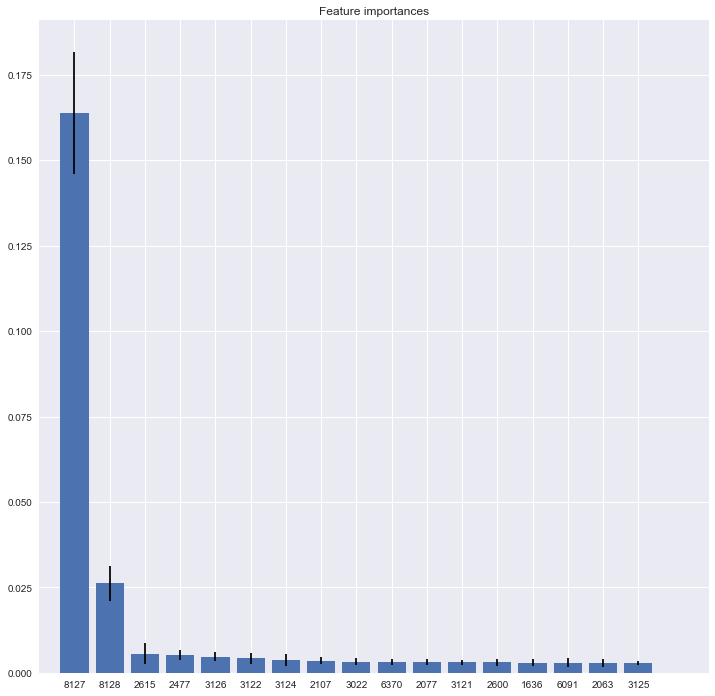

In [142]:
# Plot the feature importances of the forest
plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(0,17,1), importances[indices[0:17]],yerr=std[indices[0:17]], align="center")
plt.xticks(range(0,17,1), indices[0:17])
plt.xlim([-1, 18])
plt.show()

#### Presentation Chart

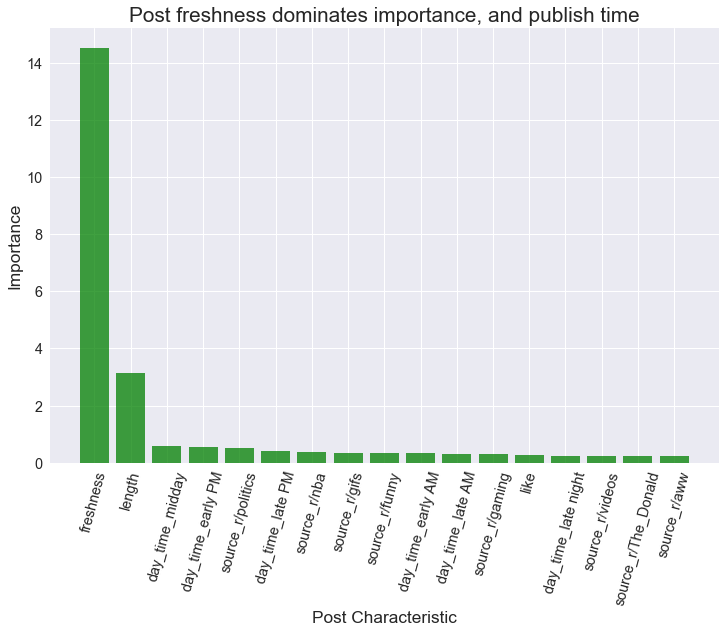

In [725]:
sns.set(style = 'darkgrid')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ind = np.arange(0,17,1)

_ = plt.bar(ind, 100*features['importance'][0:17],alpha=0.75,color='g')

_ = plt.xticks(ind, features.index[0:17],fontsize='large',rotation=75)

_ = plt.yticks(fontsize='large')
_ = plt.xlabel('Post Characteristic',fontsize='x-large')
_ = plt.ylabel('Importance',fontsize='x-large')
_ = plt.title('Post freshness dominates importance, and publish time',fontsize='xx-large')

#plt.savefig('presentation/importance.jpg')

### K-Nearest Neighbors

In [666]:
from sklearn.preprocessing import StandardScaler

dummies = [c for c in X_train.columns if any(['source_' in c,'day_time_' in c])]

Xd = X_train[dummies[1:-1]]
Xt = X_train[['freshness','length']]

scaler = StandardScaler()
Xs =scaler.fit_transform(Xt)
Xs = pd.DataFrame(Xs,index=X_train.index)

Xds = pd.concat([Xd,Xs],axis=1,join='inner')

assert Xds.shape[0] == X_train.shape[0]

In [663]:
basic_knn = KNeighborsClassifier(n_neighbors=10,weights='distance',n_jobs=-1)
basic_knn.fit(Xds,y_train)

cval = cross_val_score(basic_knn,Xds,y_train,cv=5)
print(cval)

[ 0.77263008  0.76336422  0.76514612  0.76977904  0.76158232]


In [669]:
print('KNN score: {}'.format(cval.mean()))

KNN score: 0.7665003563791875


In [667]:
# score test data
# apply same transformations

# get dummies
Xd_test = X_test[dummies[1:-1]]
# get continuous vars
Xt_test = X_test[['freshness','length']]
Xs_test = scaler.transform(Xt_test)
Xs_test = pd.DataFrame(Xs_test,index=X_test.index)

# simplify model (remove text features) to achieve convergence
# transform with best vectorizer
#Xtfidf_test_data = tfidf.transform(X_test['clean_titles'])
# to dense
#Xtfidf_test = pd.DataFrame(Xtfidf_test_data.todense(),
#                      columns=tfidf.get_feature_names(),
#                      index=X_test.index)
# join independent vars
Xds_test = pd.concat([Xd_test,Xs_test],axis=1,join='inner')
# verify
assert Xds_test.shape[0] == X_test.shape[0]
# score
knn_score = basic_knn.score(Xds_test,y_test)
print("{} Test Score:\t{:0.3}".format("KNN", knn_score.round(3)))

KNN Test Score:	0.773


In [670]:
from sklearn.metrics import confusion_matrix

predicts = basic_knn.predict(Xds_test)
confusion_matrix(predicts,y_test)

array([[4052,  876],
       [ 488,  598]])

knn_parameters = {
    'n_neighbors':[1,10,15,25,50,75,100],
    'weights':['uniform','distance'],
    'p':[1,2]
}

knn = KNeighborsClassifier()

knn_randomsearcher = RandomizedSearchCV(knn, knn_parameters,
                                        n_iter=15,random_state=42,
                                        verbose=1, cv=3,n_jobs=-1)
knn_randomsearcher.fit(Xds_tfidf,y_train)

In [ ]:
print('RandomizedSearch')
print(knn_randomsearcher.best_params_)
print(knn_randomsearcher.best_score_)

### Logistic Regression

The logistic regression seems overfit (accuracy score = 0.99), failed to converge at least once, and my efforts to implement Lasso regularization failed (or took longer than I was willing to give it due to time constraints).

In [639]:
logistic = LogisticRegressionCV(Cs=10,cv=5,solver='saga',penalty='l1',n_jobs=-1,max_iter=100) 
logistic.fit(Xdt_tfidf,y_train)

print(logistic.scores_)
print(logistic.score(Xdt_tfidf,y_train))

/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


KeyboardInterrupt: 

In [ ]:
log_parameters = {
    'C':np.logspace(0, 5, 200),
    'penalty':['l1','l2']}

randomsearcher = RandomizedSearchCV(LogisticRegression(),
                            log_parameters,
                            verbose=1,
                            n_iter=25,
                            cv=3,n_jobs=-1) 
randomsearcher.fit(Xc,yc)

print(randomsearcher.best_score_)
best_log = randomsearcher.best_params_
print(best_log)

best_logmodel = randomsearcher.best_estimator_